## Neptune

In [37]:
!pip install hpsklearn
!pip install --upgrade --quiet neptune-client
!pip install neptune-optuna

In [46]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from hyperopt import tpe

import neptune.new as neptune

In [47]:
import neptune.new as neptune

run = neptune.init(
    project="julia.grzegorowska/ml-project",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0YzMwMDM2OC04YzdlLTQxOGEtYmEzYi0xZTA3ZmQzMjlkNzIifQ==",
)

params = { "optimizer": "Julia"}
run["parameters"] = params

def send_data_neptune(data, plot_name):
    """ Sending array with data to neptune"""
    for epoch in range(0, len(data)):
      run[plot_name].log(data[epoch])

def single_record(record, record_name):
    """ Sending single record to neptune """
    run[record_name] = record

def stop_run():
    """ Stoping run at the end of the program """
    run.stop()

https://app.neptune.ai/julia.grzegorowska/ml-project/e/MLPROJ-7
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Data Standardization


In [78]:
test_data = pd.read_csv("Data/test_data.csv", header=None)
train_data = pd.read_csv("Data/train_data.csv",header=None)
train_labels = pd.read_csv("Data/train_labels.csv", header=None)

In [80]:
std = StandardScaler()

train_std_X = std.fit_transform(train_data)
test_std_X = std.fit_transform(test_data)


In [81]:
train_std_X

array([[ 0.95660292, -2.09099486, -0.77931943, ...,  0.97515449,
        -0.29931377,  1.71555315],
       [ 0.08178981,  0.38006341, -0.00743089, ..., -1.46515745,
         0.42615765, -1.34078292],
       [ 0.8440928 , -0.98910904,  0.09260166, ..., -1.9793275 ,
         1.08285495,  1.27838984],
       ...,
       [ 0.21857525, -0.77118474, -0.38308582, ...,  1.00854261,
        -0.45518027, -2.68584292],
       [ 2.88823113,  0.41804346, -0.90701198, ...,  0.69995407,
         0.49753412,  0.21998097],
       [-0.69910586,  0.55454642, -0.5687569 , ..., -1.05816134,
        -1.54371965, -1.09490866]])

In [82]:
test_std_X

array([[ 0.61582363,  0.37491104, -2.08067563, ...,  0.71836586,
         0.86629354, -0.10144485],
       [ 0.35667394, -0.42330546,  0.31327079, ..., -0.3899396 ,
        -0.23927748, -1.63772235],
       [-0.04205583, -1.10314309, -0.66863956, ...,  0.61260743,
        -0.65838105, -1.17603139],
       ...,
       [-0.6574014 , -0.6157557 , -1.13091069, ...,  1.46662386,
         0.46339276,  1.86944689],
       [-1.19298386,  0.07635118,  0.29608954, ...,  1.95800225,
         0.1950755 ,  0.1470618 ],
       [-0.75052271, -0.93717947,  1.06542746, ..., -0.88280821,
        -1.29259975,  0.87074824]])

In [85]:
train_X, test_X, train_y, test_y = train_test_split(train_std_X, train_labels, test_size=0.3, random_state=2)

## Problem: unbalanced dataset
Possible solutions: Combined under and oversampling

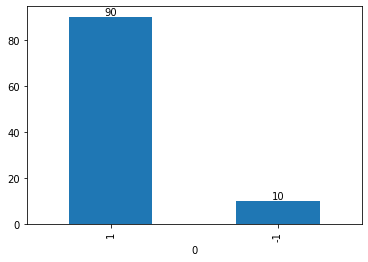

In [86]:
temp_df = (train_labels.groupby(0).size().sort_values(ascending=False) / train_labels.groupby(0).size().sort_values(ascending=False).sum())*100
ax = temp_df.plot(kind='bar')
ax.bar_label(ax.containers[0])  
plt.show()

In [87]:
def combined_random_sampling(X, y: np.array) -> list:
    
    oversampling = RandomOverSampler(random_state=42)
    undersampling = RandomUnderSampler(random_state=42, replacement=True)

    pipeline = Pipeline(steps=[('o', oversampling), ('u', undersampling)])

    X_resampled, y_resampled = pipeline.fit_resample(X, y)
    
    return [X_resampled, y_resampled]

In [88]:
X_resampled, y_resampled = combined_random_sampling(train_X, train_y)

def save_data(train_X, test_X, train_y: np.array) -> None:
    """Save to npy file"""
    
    np.save('processed_train_X.npy', train_X)
    np.save('processed_test_X.npy', test_X)
    np.save('processed_train_y.npy', train_y)
    
    print("Saving has been completed.")

save_data(X_resampled, test_X, y_resampled)

In [89]:
y_resampled

,0
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
4711,1
4712,1
4713,1
4714,1


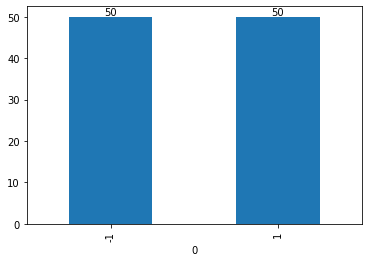

In [90]:
temp_df = (y_resampled.groupby(0).size().sort_values(ascending=False) / y_resampled.groupby(0).size().sort_values(ascending=False).sum())*100
ax = temp_df.plot(kind='bar')
ax.bar_label(ax.containers[0])  
plt.show()

In [ ]:
df = pd.DataFrame(X_resampled, index=None, columns=None)

In [ ]:
def correlation_heatmap(data: pd.DataFrame) -> plt:
    """Correlation heatmap for preprocessed train data"""
    
    plt.figure(figsize=(16.9, 8))
    heat_mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    sns.heatmap(data.corr(), mask=heat_mask, vmin=-1, vmax=1, annot=True)
    plt.title("Correlation heatmap for preprocessed train data")
    
    return plt.show()

In [ ]:
correlation_heatmap(df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=seed)

In [94]:
def pipe_basic_model(x_1: np.array, x_2: np.array, y_1: np.array, y_2: np.array) -> None:
    """
    Base line model picking with repeated skf, GridSearchCV in pipeline
    :param x_1: np.array: train of data after over and undersampling
    :param x_2: np.array: test of data after over and undersampling
    :param y_1: np.array: train of values after over and undersampling
    :param y_2: np.array: test of values after over and undersampling
    :return: None
    """
    
    pipe = Pipeline([("classifier", SVC(kernel="linear", C=1, random_state=seed))])
    
    search_space = [
        {"classifier": [SVC(random_state=seed)]},
        {"classifier": [LinearSVC(random_state=seed)]},
        {"classifier": [LogisticRegression(random_state=seed)]},
        {"classifier": [KNeighborsClassifier()]},
        {"classifier": [MLPClassifier(random_state=seed)]},
        {"classifier": [AdaBoostClassifier(random_state=seed)]},
        {"classifier": [GradientBoostingClassifier(random_state=seed)]},
        {"classifier": [RandomForestClassifier(random_state=seed)]},
        {"classifier": [ExtraTreesClassifier(random_state=seed)]},
        {"classifier": [AdaBoostClassifier(random_state=seed)]},
        {"classifier": [GaussianNB()]}
    ]
    
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
    gridsearch = GridSearchCV(pipe, search_space, cv=rskf, verbose=1, n_jobs=-1)
    best_model = gridsearch.fit(x_1, y_1)
    y_pred = best_model.predict(x_2)
    
    print(f"\nBest model: {best_model.best_estimator_.get_params()['classifier']}")
    print("\nMicro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_2, y_pred, average='micro'))
    
    single_record(f1_score(y_2, y_pred, average='micro'), "f1-score")

In [ ]:
pipe_basic_model(X_train, X_test, y_train, y_test)

In [ ]:
def hyperopt_model(x_1: np.array, x_2: np.array, y_1: np.array, y_2: np.array) -> None:
    """
    Hyperopt model picking
    :param x_1: np.array: train of data after over and undersampling
    :param x_2: np.array: test of data after over and undersampling
    :param y_1: np.array: train of values after over and undersampling
    :param y_2: np.array: test of values after over and undersampling
    :return: None
    """

    model = HyperoptEstimator(
        classifier=any_classifier("cla"),
        preprocessing=any_preprocessing("pre"),
        algo=tpe.suggest,
        max_evals=10,
        trial_timeout=30
    )
    
    model.fit(x_1, y_1)
    y_pred = model.predict(x_2)
    
    print(f"\nBest model: {model.best_model()}")
    print("\nMicro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_2, y_pred, average='micro'))
    
    send_data_neptune(y_pred, "y_pred")
    single_record(f1_score(y_2, y_pred, average='micro'), "Micro-averaged F1 Score")

In [ ]:
hyperopt_model(X_train, X_test, y_train, y_test)

In [ ]:
stop_run()